# Importing required libraries

In [10]:
import time
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 
sns.set(color_codes=True)

# Read and format data

In [55]:
#bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
#dogeusd.csv

#df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df = pd.read_csv("ethusd.csv")
#df.drop(['Volume_(BTC)', 'Volume_(Currency)'], axis=1, inplace=True)

TIME_KEY = 'Timestamp'
PRICE_KEY = 'Weighted_Price'

TIME_KEY = 'time'
PRICE_KEY = 'open'
END = len(df.index) - 1
print(END)

2194355


,time,open,close,high,low,volume
2194351,1625223120000,2034.8,2031.8,2034.8,2031.4,6.027430
2194352,1625223180000,2031.5,2032.7,2034.9,2031.4,1.246214
2194353,1625223240000,2032.7,2032.5,2033.9,2031.5,4.500168
2194354,1625223300000,2032.8,2035.7,2036.8,2031.9,16.859664
2194355,1625223360000,2035.4,2039.4,2039.9,2035.1,41.619427


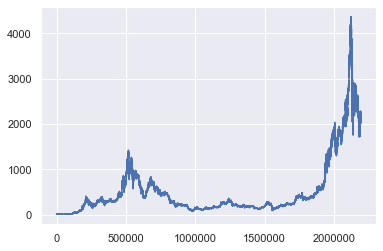

In [56]:
x = df[TIME_KEY]
y = df[PRICE_KEY]

plt.plot(y)
df.head()
df.tail()

# Important Constants

In [39]:
minutes_in_day = 24*60

# example day
lower = 3 * 10**6
upper = lower + minutes_in_day
day = df.loc[lower:upper]
prices = day[PRICE_KEY]

# Helper functions for trading, calculations, visualization

In [40]:
#moving average, most useful in up/down trends over side-to-side

def calc_sd(rank, time_delta, current_index):
    sd = df[PRICE_KEY][current_index-rank*time_delta:current_index].std()
    nan_offset = rank - df[PRICE_KEY][current_index-rank*time_delta:current_index].count()
    return (sd, nan_offset)

def calc_mov_avg(rank, time_delta, current_index):
    average = df[PRICE_KEY][current_index-rank*time_delta:current_index].mean()
    nan_offset = rank - df[PRICE_KEY][current_index-rank*time_delta:current_index].count()
    return (average, nan_offset)

def efficient_mov_avg(prev_avg, rank, time_delta, index, nan_offset):
    old_value = df[PRICE_KEY].iloc[index-time_delta*rank-1]
    new_value = df[PRICE_KEY].iloc[index-1]
    
    old_is_nan = np.isnan(old_value)
    new_is_nan = np.isnan(new_value)
    
    old_divisor = rank-nan_offset # accounting for prev NaN's
    
    if old_is_nan:
        old_value = 0;
        nan_offset-=1
        
    if new_is_nan:
        new_value = 0
        nan_offset+=1
        
    new_divisor = rank - nan_offset # accounting for new NaN's
    
    if new_divisor == 0: # in the event all prev values are NaN
        avg = 0
        
    else:
        avg = (prev_avg * old_divisor - old_value + new_value)/new_divisor
    
    return (avg,nan_offset)

# trade/buy

def get_curr_price(index):
    return df[PRICE_KEY].iloc[index]

def execute_buy(curr_price, cash, coin, prop):
    if cash <= 0:
        return (cash,coin, False)
    coin += cash*prop / curr_price
    cash -= cash*prop
    return (cash,coin, True)

def execute_sell(curr_price, cash, coin, prop):
    if coin <= 0:
        return (cash,coin, False)
    cash += coin*prop * curr_price
    coin -= coin*prop
    return (cash,coin, True)

# analysis

def list_assets(start_cash, cash, coin, end_index, output = True):
    end_value = get_curr_price(end_index)
    total = (end_value * coin + cash)
    delta = ( ((total-start_cash)/start_cash)*100)
    
    if output:
        print("cash: %s" % cash) 
        print("coin: %s " % coin)
        print("total value: %s" % total)
        print("percent change: %s \n" % delta )
        
    return delta
    
def display_data(overall_wealth, btc, cash, sample_rate, start, end, rank, time_delta):
    scaler = MinMaxScaler()
    overall_wealth = scaler.fit_transform(np.array(overall_wealth).reshape(-1,1))
    overall_btc_price = scaler.fit_transform(np.array(df[PRICE_KEY][start-rank*time_delta:end:sample_rate]).reshape(-1,1))
    btc = scaler.fit_transform(np.array(btc).reshape(-1,1))
    cash = scaler.fit_transform(np.array(cash).reshape(-1,1))
    
    
    plt.plot(df[TIME_KEY][start:end:sample_rate],overall_wealth, label='overall wealth')
    plt.plot(df[TIME_KEY][start-rank*time_delta:end:sample_rate],overall_btc_price, label='overall btc price')
    #plt.plot(btc, label='btc owned')
    #plt.plot(cash, label='cash on-hand')
    plt.legend(loc='best')
    plt.show()
    
def display_price_over_time_period(figure_index, start, end):
    plt.figure(figure_index)      
    plt.plot(df[TIME_KEY][start:end],df[PRICE_KEY][start:end])
    plt.title(f'BTC Price from {start} to {end}')
    plt.xlabel('Time (s)')
    plt.ylabel('Price (USD)')

# Simple Buy & Hold

In [58]:
end = END # across all data
start = 0 # across all data

cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
trade_prop = 1

cash,coin,success = execute_buy(get_curr_price(start),cash,coin,trade_prop)
cash,coin,success = execute_sell(get_curr_price(end),cash,coin,trade_prop)


res = list_assets(starting_wealth,cash,coin,end)

cash: 197669.22404583858
coin: 0.0 
total value: 197669.22404583858
percent change: 19666.922404583856 



# Demonstration of efficient vs in-efficient moving average calculations

In [34]:
start = 3 * (10**6)
end = start + 60*minutes_in_day
moving_avg_rank = 200
time_delta = 1 # each increment/decrement of 1 represents one minute
#time_delta = 60 # data taken at each hour from start
#time_delta = 1440 # data taken at each day from start


# efficient moving average calculation

start_time = time.time()
prev_avg, nan_offset = calc_mov_avg(moving_avg_rank, time_delta, start-1*time_delta) #pre-processing

for i in range(start, end):
   
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, moving_avg_rank, time_delta, i, nan_offset)
    prev_avg = mov_avg

    
efficient_time = time.time() - start_time


# inefficient moving average calculation

start_time = time.time()

for i in range(start, end):  

    mov_avg = calc_mov_avg(moving_avg_rank, time_delta, i)[0]
    
inefficient_time = time.time() - start_time


print("efficient: %s seconds" % efficient_time)
print("in-efficient: %s seconds" % inefficient_time)
print("time saved: %s seconds" % (inefficient_time-efficient_time))

efficient: 3.572589159011841 seconds
in-efficient: 30.66028904914856 seconds
time saved: 27.08769989013672 seconds


# Moving Average Calculations Testing

In [35]:
#For verification of accuracy of calculating moving averages

a = np.array([element+.25*element for element in range(20)])
rank = 50
time_delta = 60

start= 3 * 10**6
end = start + minutes_in_day

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start-1) # pre-processing
for i in range(start, end):
    
    mov_avg, nan = calc_mov_avg(50,60,i) # actual
    
    eff_mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset) # approximated
    prev_avg = eff_mov_avg
    
    #rounding values for display purposes, but not for error calculations
    sample_rate = 200
    if (i-start) % sample_rate == 0:
        print(f'APPROX: {round(eff_mov_avg,4)}, ACTUAL: {round(mov_avg,4)}, ERROR: {abs((eff_mov_avg-mov_avg)/mov_avg)}%')



APPROX: 3669.7999, ACTUAL: 3669.7999, ERROR: 0.0%
APPROX: 3672.2698, ACTUAL: 3672.2698, ERROR: 0.0%
APPROX: 3681.2321, ACTUAL: 3681.2321, ERROR: 1.8529693464759484e-15%
APPROX: 3700.5572, ACTUAL: 3700.5572, ERROR: 3.6865854708434773e-16%
APPROX: 3730.1517, ACTUAL: 3730.1517, ERROR: 4.876448826674819e-16%
APPROX: 3757.8719, ACTUAL: 3757.8719, ERROR: 0.0%
APPROX: 3783.3174, ACTUAL: 3783.3174, ERROR: 4.807921802576786e-16%
APPROX: 3805.6857, ACTUAL: 3805.6857, ERROR: 1.0754241027287118e-15%


# Moving Average Trading Simulation

In [59]:
#buy when above, sell when below
#golden cross (50 day crosses above 200 day, bearish to bullish) vs death cross 

start = int(3.004 * 10**6 + 0*len(day))
end = start + 60*len(day)
rank = 50
time_delta = 1440 #1, 60, 1440 for minutes, hours, days, respectively

#end = END # TOGGLE for all data
#start = 0 + time_delta*rank # TOGGLE for all data

cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #pre-processing
prev_price = get_curr_price(start-1)

sample_rate = 1
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len

buy_proportion = 1
sell_proportion = 1
arr_index = 0

for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if curr_price > mov_avg and prev_price < mov_avg: #handles NaN
        buy+=1
        cash,coin,success = execute_buy(curr_price, cash, coin, buy_proportion)

    elif curr_price < mov_avg and prev_price > mov_avg: #handles NaN
        sell+=1
        cash,coin,success = execute_sell(curr_price, cash, coin, sell_proportion)

    if (i-start) % sample_rate == 0:
        btc_value_dollars[arr_index] = coin * curr_price
        cash_value_dollars[arr_index] = cash
        overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
        arr_index+=1
        
    prev_price = curr_price
    prev_avg = mov_avg 
        
list_assets(starting_wealth, cash, coin, end)
display_data(overall_wealth, btc_value_dollars, cash_value_dollars, sample_rate, start, end, rank, time_delta)

IndexError: single positional indexer is out-of-bounds

# Percentage Trigger Trading Simulation

trade prop = 0.9: (trigger = 0.01, profit = 25.1077%)
trade prop = 0.9: (trigger = 0.02, profit = 19.5894%)
trade prop = 0.9: (trigger = 0.03, profit = 24.4406%)
trade prop = 0.9: (trigger = 0.04, profit = 19.1291%)
trade prop = 0.9: (trigger = 0.05, profit = 0.6771%)
 
trade prop = 1.0: (trigger = 0.01, profit = 13.7246%)
trade prop = 1.0: (trigger = 0.02, profit = 2.0301%)
trade prop = 1.0: (trigger = 0.03, profit = 3.0625%)
trade prop = 1.0: (trigger = 0.04, profit = 17.2976%)
trade prop = 1.0: (trigger = 0.05, profit = 5.3314%)
 


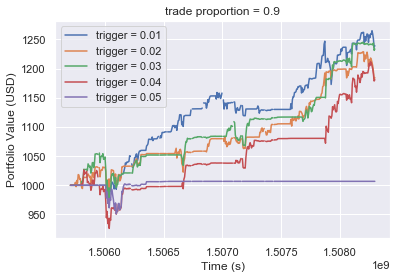

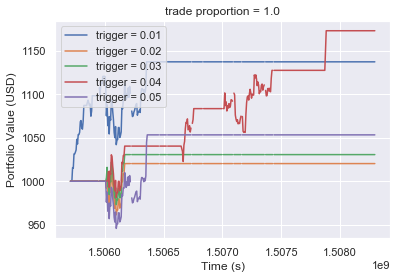

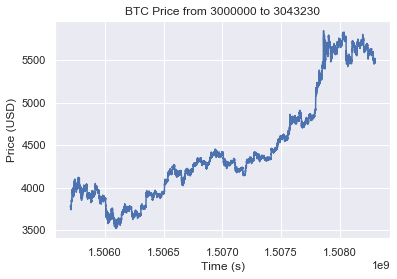

In [23]:
#simple buying and selling when percentage threshold is met

#print(f'{cash},{coin}') # for debugging
#print(f'{curr_price} buy')

def calc_thresholds(index, trigger_threshold):
    reference_price = get_curr_price(index)
    sell = (1 + trigger_threshold) * reference_price
    buy = (1 - trigger_threshold) * reference_price
    return (reference_price, sell, buy)
    
start = int(3 * 10**6 + 0*len(day)) # TOGGLE for start of time period
end = start + 30*len(day) # TOGGLE for end of time period

#end = END # TOGGLE for all data
#start = 0 # TOGGLE for all data

sample_rate = 100
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len


buy_proportions = [el/10 for el in range(9,11)] # TOGGLE this range to allow for trading w/ different trading proportions

trigger_thresholds = [el/100 for el in range(1,6)] # TOGGLE this range to allow for different percentage triggers
deltas = [float] * len(trigger_thresholds) # holds percentage changes of portfolio value
deltas_index = 0
figure = 0

for buy_prop in buy_proportions:
    
    deltas_index = 0
    plt.figure(figure)
    plt.title(f'trade proportion = {buy_prop}')
    
    for trigger_threshold in trigger_thresholds:
        
        cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
        starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
        
        reference_price, sell_threshold, buy_threshold = calc_thresholds(start-1, trigger_threshold)
        #print(f'ref price: {reference_price}')
        for i in range(start, end):
            
            curr_price = get_curr_price(i)

            if curr_price >= sell_threshold: #handles NaN
                buy+=1
                cash, coin, succcess = execute_sell(curr_price, cash, coin, buy_prop)
                if success:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            elif curr_price <= buy_threshold: #handles NaN
                sell+=1
                cash, coin, success = execute_buy(curr_price, cash, coin, buy_prop)
                if success:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            if (i-start) % sample_rate == 0:
                btc_value_dollars[arr_index] = coin * curr_price
                cash_value_dollars[arr_index] = cash
                overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
                arr_index+=1
                
        plt.plot(df[TIME_KEY][start:end:sample_rate],overall_wealth, label=f'trigger = {trigger_threshold}') # uncomment to graph different trigger thresholds
        deltas[deltas_index] = list_assets(starting_wealth, cash, coin, end, output=False)
        deltas_index+=1

    plt.legend(loc='best')
    plt.xlabel('Time (s)')
    plt.ylabel('Portfolio Value (USD)')
   
    for i in range(len(trigger_thresholds)):   
        print(f'trade prop = {buy_prop}: (trigger = {trigger_thresholds[i]}, profit = {round(deltas[i],4)}%)')
    print(' ')
    figure+=1
    
display_price_over_time_period(figure, start, end)

# Various Trading Simulations Utilizing Bollinger Bands + Visualization

In [ ]:
#price < low band: buying position 
#price > high band: selling position

sd_map = {
    10:1.5,
    14:2,
    20:2,
    50:2.5,
}

start = int(4.166 * 10**6 + 0*len(day)) # good demonstration day

#start = int(3.5 * 10**6)
end = start + int(60*minutes_in_day) # across two months

end = END # TOGGLE for all data
start = 0 + time_delta*rank # TOGGLE for all data

rank = 14
time_delta = 1440 # TOGGLE 1, 60, 1440 for minutes, hours, days, respectively
time_interval = end-start

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #preprocessing
prev_price = get_curr_price(start-1)

sample_rate = 1
trade_prop = 1

arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

upper_band = [float] * arr_len
moving_avg = [float] * arr_len
lower_band = [float] * arr_len
bb_values = [float] * arr_len
overall_wealth_1 = [float] * arr_len
overall_wealth_2 = [float] * arr_len


arr_index = 0

# for first algo
cash_1, coin_1, buy_1, sell_1 = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth_1 = cash_1 + coin_1 * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash_1

# for second algo
cash_2, coin_2, buy_2, sell_2 = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth_2 = cash_2 + coin_2 * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash_2


for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if (i-start) % sample_rate == 0:
        
        sd = calc_sd(rank, time_delta, i)[0]
        upper_band[arr_index] = mov_avg + (sd * sd_map[rank])
        moving_avg[arr_index] = mov_avg
        lower_band[arr_index] = mov_avg - (sd * sd_map[rank])
        bb_values[arr_index] = (curr_price - mov_avg) / (sd * sd_map[rank])

        #strategy 1
        if curr_price >= upper_band[arr_index] and prev_price < upper_band[arr_index]: #sell on upper band
            cash_1, coin_1, succcess_1 = execute_sell(curr_price, cash_1, coin_1, trade_prop)

        elif curr_price <= lower_band[arr_index] and prev_price > lower_band[arr_index]: #buy on lower band
            cash_1, coin_1, succcess_1 = execute_buy(curr_price, cash_1, coin_1, trade_prop)

        #strategy 2
        if bb_values[arr_index] >= 1: #sell on >= 1
            cash_2, coin_2, succcess_2 = execute_sell(curr_price, cash_2, coin_2, trade_prop)
 
        elif bb_values[arr_index] <= 0: #buy on <= 0
            cash_2, coin_2, succcess_2 = execute_buy(curr_price, cash_2, coin_2, trade_prop)
    
        
        overall_wealth_1[arr_index] = coin_1 * curr_price + cash_1
        overall_wealth_2[arr_index] = coin_2 * curr_price + cash_2
        arr_index+=1
        
    prev_avg = mov_avg
    prev_price = curr_price

print("Strategy 1 Results: \n")
res=list_assets(starting_wealth_1, cash_1, coin_1, end) 

print("Strategy 2 Results: \n")
res=list_assets(starting_wealth_2, cash_2, coin_2, end)

time_space = df[TIME_KEY][start:end:sample_rate]

plt.figure(0)
plt.plot(time_space, upper_band, label='upper band')
plt.plot(time_space, moving_avg, label='simple moving average')
plt.plot(time_space, lower_band, label='lower band')
plt.plot(time_space, df[PRICE_KEY][start:end:sample_rate], label='BTC price')
plt.title(f'Visualization of BTC BB from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.figure(1)
plt.plot(time_space, bb_values, label='bb value')
plt.plot(time_space, [0] * arr_len, label='value = 0')
plt.plot(time_space, [1] * arr_len, label='value = 1')
plt.title(f'Bollinger Band Values from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Bollinger Band Value')
plt.legend(loc='best')

plt.figure(2)
plt.plot(time_space, overall_wealth_1, label='strategy 1')
plt.plot(time_space, overall_wealth_2, label='strategy 2')
plt.title('Portfolio Value vs Time for Strategies 1 & 2')
plt.xlabel('Time (s)')
plt.ylabel('Net Worth (USD)')
plt.legend(loc='best')

# Relative Strength Index Trading Strategy

cash: 0.0
coin: 0.0036025477312386237 
total value: 7.332625652163095
percent change: -99.26673743478369 



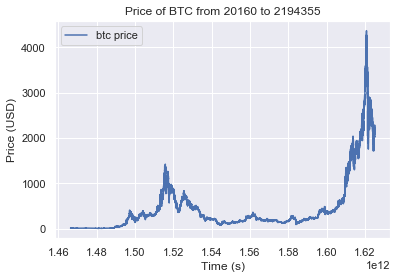

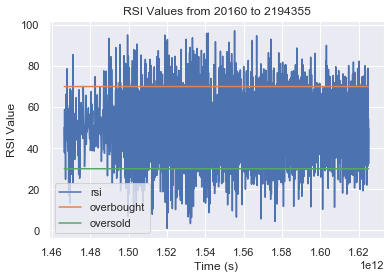

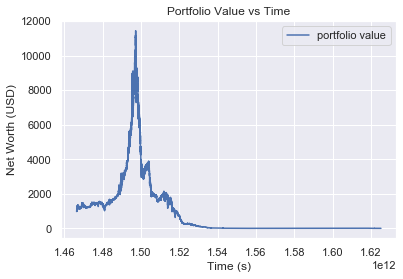

In [57]:
def calc_avg_gain_loss(start, rank, time_delta):
    gain = 0
    loss = 0
    
    for i in range(start-rank*time_delta, start-1):
        curr_price = get_curr_price(i)
        next_price = get_curr_price(i+1)
        delta = next_price - curr_price
        
        if delta > 0:
            gain+=delta
        elif delta < 0:
            loss+=abs(delta)
            
    avg_gain = gain / rank
    avg_loss = loss / rank 

    return (avg_gain, avg_loss)

rank = 14
smoothing_weight = rank-1

time_delta = 1440 # for days
sample_rate = 1
trade_prop = 1

overbought = 70
oversold = 30
        
start = 3 * 10**6 # good demonstration day
end = start + 60*minutes_in_day

end = END # TOGGLE for all data
start = 0 + time_delta*rank # TOGGLE for all data


cash, coin, buy, sell = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
        

arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

overall_wealth = [float] * arr_len
rsi_values = [float] * arr_len

prev_avg_gain, prev_avg_loss = calc_avg_gain_loss(start,rank,time_delta)
prev_price = get_curr_price(start-1)

for i in range(start,end):
    curr_price = get_curr_price(i)
    delta = curr_price - prev_price
    
    curr_gain = 0 
    curr_loss = 0

    if delta > 0: #increase from last price
        curr_gain = delta
    elif delta < 0: #decrease from last price
        curr_loss = abs(delta)
    
    avg_gain = (prev_avg_gain*smoothing_weight + curr_gain)/rank
    avg_loss = (prev_avg_loss*smoothing_weight + curr_loss)/rank
    relative_strength = avg_gain / avg_loss
    rsi_values[i-start] = 100 - (100 / (1 + relative_strength))
    
    if rsi_values[i-start] >= overbought:
        cash, coin, success = execute_sell(curr_price, cash, coin, trade_prop)
        
    elif rsi_values[i-start] <= oversold:
        cash, coin, success = execute_buy(curr_price, cash, coin, trade_prop)
        
    overall_wealth[i-start] = curr_price * coin + cash
    prev_avg_gain = avg_gain
    prev_avg_loss = avg_loss
    prev_price = curr_price
    #print(f'{cash},{coin}')
    
res = list_assets(starting_wealth, cash, coin, end)


time_span = df[TIME_KEY][start:end]

plt.figure(0)
plt.plot(time_span[::sample_rate], df[PRICE_KEY][start:end:sample_rate], label='btc price')
plt.title(f'Price of BTC from {start} to {end}')
plt.ylabel('Price (USD)')
plt.xlabel('Time (s)')
plt.legend(loc='best')
    
plt.figure(1)  
step = 500 #plotted w/ large step value to make more visible, TOGGLE to 1 for full set of data
plt.plot(time_span[::step], rsi_values[::step], label='rsi') # rsi values
plt.plot(time_span, [overbought] * arr_len, label='overbought') # overbought marker
plt.plot(time_span, [oversold] * arr_len, label='oversold') # underbought marker
plt.title(f'RSI Values from {start} to {end}')
plt.ylabel('RSI Value')
plt.xlabel('Time (s)')
plt.legend(loc='best')
    
plt.figure(2)
plt.plot(time_span, overall_wealth, label='portfolio value')
plt.title('Portfolio Value vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Net Worth (USD)')
plt.legend(loc='best')   